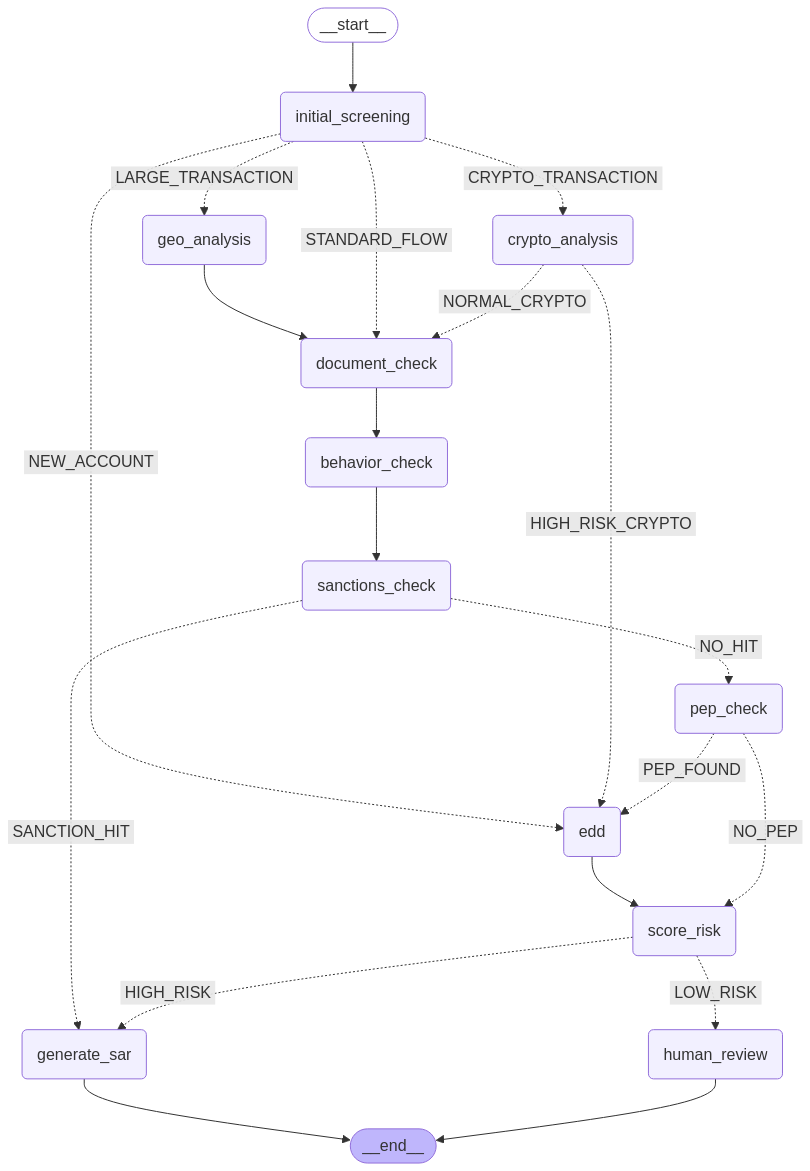


Processing Case 1: Repeated sub-threshold transactions (structuring)

AML Analysis Report
Final Risk Score: 45/100
Decision Path: start → document_analysis → behavior_analysis → sanctions_check → pep_check → human_review

🔍 LLM Analysis Findings:
Document Risks:
  ['INVOICE_MISMATCH', 'HIGH', 'RISK']


⚠️  Requires Human Review
   Deadline: N/A


Processing Case 2: High-risk country transaction

AML Analysis Report
Final Risk Score: 65/100
Decision Path: start → geo_analysis → document_analysis → behavior_analysis → sanctions_check → pep_check → sar_generation

🔍 LLM Analysis Findings:
Document Risks:
  ['RISK', 'CODES', 'SHELL_COMPANY']


📄 SAR Generated: 31beabb00abe


Processing Case 3: PEP transaction

AML Analysis Report
Final Risk Score: 95/100
Decision Path: start → geo_analysis → document_analysis → behavior_analysis → sanctions_check → pep_check → enhanced_dd → sar_generation

🔍 LLM Analysis Findings:
Document Risks:
  ['RISK', 'CODES', 'SHELL_COMPANY', 'TRADE_BASED_LAUNDERIN

In [10]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Optional
from langchain_groq import ChatGroq
import datetime
import statistics
import hashlib
import asyncio
import re
import json

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


import nest_asyncio
nest_asyncio.apply()

# Initialize LLM
llm = ChatGroq(
    model="llama3-70b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# ======================
# Enhanced Configuration
# ======================
high_risk_countries = ["IR", "KP", "SY", "CU", "MM", "RU"]
tax_havens = ["KY", "VG", "BM", "PA", "MT", "AE"]
sanctioned_entities = ["narcotics_cartel_xyz", "terror_group_abc", "sanctioned_russian_bank"]
darknet_markets = ["AlphaMarket", "Dark0d3", "Hydra"]

# ======================
# Enhanced State Definition
# ======================
class AMLState(TypedDict):
    transaction: dict
    customer: dict
    risk_score: int
    alerts: List[str]
    investigation: dict
    llm_analysis: dict
    risk_factors: List[str]
    decision_path: List[str]
    reporting_status: Optional[str]
    documents: List[str]
    pep_status: Optional[bool]
    sanction_hits: List[str]
    case_id: Optional[str]
    transaction_count: int

# ======================
# Enhanced Utility Functions
# ======================
def generate_case_id():
    return hashlib.sha256(str(datetime.datetime.now()).encode()).hexdigest()[:12]

def check_pep_database(name: str) -> bool:
    return any(keyword in name.lower() for keyword in ["gov", "minister", "official"])

def check_sanctions_list(entities: List[str]) -> List[str]:
    return [e for e in entities if any(s in e.lower() for s in [s.lower() for s in sanctioned_entities])]

# ======================
# Enhanced Node Implementations
# ======================
def update_path(state: AMLState, step: str) -> AMLState:
    return {**state, "decision_path": state["decision_path"] + [step]}

async def async_document_analysis(state: AMLState) -> AMLState:
    """Enhanced document analysis with pattern recognition"""
    state = update_path(state, "document_analysis")
    if not state.get("documents"):
        return {**state, "alerts": state["alerts"] + ["MISSING_DOCUMENTS"]}
    
    analysis = await llm.ainvoke(
        f"""Analyze these documents for AML risks. Respond with RISK CODES from:
        - INVOICE_MISMATCH
        - PHANTOM_SHIPMENT
        - PROHIBITED_GOODS
        - SHELL_COMPANY
        - DARKNET_CONNECTION
        - TRADE_BASED_LAUNDERING
        
        Documents: {state['documents']}"""
    )
    
    risk_codes = re.findall(r"[A-Z_]{4,}", analysis.content)
    return {**state, 
            "llm_analysis": {**state.get("llm_analysis", {}), "document_risks": risk_codes},
            "risk_factors": state["risk_factors"] + risk_codes}

def document_analysis(state: AMLState) -> AMLState:
    return asyncio.run(async_document_analysis(state))

def geographic_risk_assessment(state: AMLState) -> AMLState:
    """Check all jurisdictions in transaction path"""
    state = update_path(state, "geo_analysis")
    tx = state["transaction"]
    risk_factors = []
    
    locations = [tx["origin_country"], tx["destination_country"]] + \
                tx.get("intermediate_countries", [])
                
    for country in locations:
        if country in high_risk_countries:
            risk_factors.append(f"HIGH_RISK_{country}")
        if country in tax_havens:
            risk_factors.append(f"TAX_HAVEN_{country}")
    
    return {**state, "risk_factors": state["risk_factors"] + risk_factors}

def behavioral_analysis(state: AMLState) -> AMLState:
    """Enhanced structuring detection"""
    state = update_path(state, "behavior_analysis")
    history = state["customer"]["transaction_history"]
    current = state["transaction"]
    
    # Structuring detection
    recent_txs = [tx for tx in history 
                 if (current["timestamp"] - tx["timestamp"]).days < 1]
    recent_txs.append(current)
    
    structuring_alerts = []
    if len(recent_txs) > 3 and all(tx["amount"] < 10000 for tx in recent_txs):
        structuring_alerts.append("STRUCTURING_PATTERN")
    if len(recent_txs) > 5 and statistics.stdev(tx["amount"] for tx in recent_txs) < 500:
        structuring_alerts.append("UNIFORM_TRANSACTIONS")
    
    return {**state, "alerts": state["alerts"] + structuring_alerts}

def crypto_risk_analysis(state: AMLState) -> AMLState:
    """Cryptocurrency-specific risk assessment"""
    state = update_path(state, "crypto_analysis")
    if state["transaction"].get("asset_type") != "CRYPTO":
        return state
    
    details = state["transaction"].get("crypto_details", {})
    risks = []
    
    if details.get("mixer_used"):
        risks.append("CRYPTO_MIXER")
    if details.get("darknet_market") in darknet_markets:
        risks.append("DARKNET_CONNECTION")
    if details.get("wallet_age_days", 0) < 7:
        risks.append("NEW_WALLET")
        
    return {**state, "risk_factors": state["risk_factors"] + risks}

def sanctions_screening(state: AMLState) -> AMLState:
    state = update_path(state, "sanctions_check")
    hits = check_sanctions_list(state["transaction"]["parties"])
    return {**state, "sanction_hits": hits}

def pep_screening(state: AMLState) -> AMLState:
    state = update_path(state, "pep_check")
    is_pep = check_pep_database(state["customer"]["name"])
    return {**state, "pep_status": is_pep}

async def async_enhanced_due_diligence(state: AMLState) -> AMLState:
    state = update_path(state, "enhanced_dd")
    analysis = await llm.ainvoke(
        f"""Conduct deep AML investigation. Consider:
        - PEP status: {state['pep_status']}
        - Sanctions hits: {state['sanction_hits']}
        - Risk factors: {state['risk_factors']}
        Provide critical risk indicators in UPPERCASE."""
    )
    critical_risks = re.findall(r"\b[A-Z_]+\b", analysis.content)
    return {**state, 
            "risk_factors": state["risk_factors"] + critical_risks,
            "llm_analysis": {**state["llm_analysis"], "edd_report": analysis.content}}

def enhanced_due_diligence(state: AMLState) -> AMLState:
    return asyncio.run(async_enhanced_due_diligence(state))

def risk_scoring(state: AMLState) -> AMLState:
    """Weighted risk scoring"""
    score = 0
    
    # Critical factors
    score += 40 * len(state["sanction_hits"])
    score += 35 if state["pep_status"] else 0
    
    # Risk factors
    crypto_risks = len([rf for rf in state["risk_factors"] if "CRYPTO" in rf])
    score += 25 * crypto_risks
    
    jurisdiction_risks = len([rf for rf in state["risk_factors"] if "HIGH_RISK" in rf])
    score += 20 * jurisdiction_risks
    
    document_risks = len(state["llm_analysis"].get("document_risks", []))
    score += 15 * document_risks
    
    # Behavioral alerts
    score += 10 * len(state["alerts"])
    
    return {**state, "risk_score": min(score, 100)}

def generate_sar(state: AMLState) -> AMLState:
    """SAR generation"""
    state = update_path(state, "sar_generation")
    return {**state,
            "reporting_status": "SAR_FILED",
            "case_id": generate_case_id(),
            "sar_timestamp": datetime.datetime.now()}

def human_review(state: AMLState) -> AMLState:
    """Human review handling"""
    state = update_path(state, "human_review")
    return {**state,
            "review_status": "PENDING",
            "review_deadline": datetime.datetime.now() + datetime.timedelta(hours=24)}


# ======================
# Enhanced Conditional Routing
# ======================
def route_initial_screening(state: AMLState) -> str:
    tx = state["transaction"]
    if tx.get("asset_type") == "CRYPTO":
        return "CRYPTO_TRANSACTION"
    if tx["amount"] > 100000:
        return "LARGE_TRANSACTION"
    if state["customer"]["account_age_days"] < 7:
        return "NEW_ACCOUNT"
    return "STANDARD_FLOW"

def route_crypto_analysis(state: AMLState) -> str:
    if any("CRYPTO" in rf for rf in state["risk_factors"]):
        return "HIGH_RISK_CRYPTO"
    return "NORMAL_CRYPTO"

# ======================
# Enhanced Workflow
# ======================
workflow = StateGraph(AMLState)

nodes = [
    ("initial_screening", lambda s: update_path(s, "start")),
    ("crypto_analysis", crypto_risk_analysis),
    ("geo_analysis", geographic_risk_assessment),
    ("document_check", document_analysis),
    ("behavior_check", behavioral_analysis),
    ("sanctions_check", sanctions_screening),
    ("pep_check", pep_screening),
    ("edd", enhanced_due_diligence),
    ("score_risk", risk_scoring),
    ("generate_sar", generate_sar),
    ("human_review", human_review),
]

for name, func in nodes:
    workflow.add_node(name, func)

workflow.set_entry_point("initial_screening")

# Enhanced edge configuration
workflow.add_conditional_edges(
    "initial_screening",
    route_initial_screening,
    {
        "CRYPTO_TRANSACTION": "crypto_analysis",
        "LARGE_TRANSACTION": "geo_analysis",
        "NEW_ACCOUNT": "edd",
        "STANDARD_FLOW": "document_check"
    }
)

workflow.add_conditional_edges(
    "crypto_analysis",
    route_crypto_analysis,
    {
        "HIGH_RISK_CRYPTO": "edd",
        "NORMAL_CRYPTO": "document_check"
    }
)

workflow.add_conditional_edges(
    "sanctions_check",
    lambda s: "SANCTION_HIT" if s["sanction_hits"] else "NO_HIT",
    {"SANCTION_HIT": "generate_sar", "NO_HIT": "pep_check"}
)

workflow.add_conditional_edges(
    "pep_check",
    lambda s: "PEP_FOUND" if s["pep_status"] else "NO_PEP",
    {"PEP_FOUND": "edd", "NO_PEP": "score_risk"}
)

workflow.add_conditional_edges(
    "score_risk",
    lambda s: "HIGH_RISK" if s["risk_score"] >= 65 else "LOW_RISK",
    {"HIGH_RISK": "generate_sar", "LOW_RISK": "human_review"}
)

# Connect remaining edges
workflow.add_edge("geo_analysis", "document_check")
workflow.add_edge("document_check", "behavior_check")
workflow.add_edge("behavior_check", "sanctions_check")
workflow.add_edge("edd", "score_risk")
workflow.add_edge("generate_sar", END)
workflow.add_edge("human_review", END)

app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


def run_analysis(transaction: dict, customer: dict):
    """Execute AML workflow with formatted output"""
    initial_state = AMLState(
        transaction=transaction,
        customer=customer,
        risk_score=0,
        alerts=[],
        investigation={},
        llm_analysis={},
        risk_factors=[],
        decision_path=[],
        documents=transaction.get("documents", []),
        pep_status=None,
        sanction_hits=[],
        case_id=None
    )

    result = app.invoke(initial_state)

    print("\nAML Analysis Report")
    print("=" * 40)
    print(f"Final Risk Score: {result['risk_score']}/100")
    print(f"Decision Path: {' → '.join(result['decision_path'])}")
    
    if result["alerts"]:
        print("\n🚨 Triggered Alerts:")
        for alert in set(result["alerts"]):
            print(f"- {alert}")
    
    if result["llm_analysis"]:
        print("\n🔍 LLM Analysis Findings:")
        for key, value in result["llm_analysis"].items():
            print(f"{key.replace('_', ' ').title()}:")
            print(f"  {value}\n")

    if result.get("reporting_status") == "SAR_FILED":
        print(f"\n📄 SAR Generated: {result['case_id']}")
        #print(f"   Filed at: {result['sar_timestamp']}")
    
    if "human_review" in result["decision_path"]:
        print("\n⚠️  Requires Human Review")
        print(f"   Deadline: {result.get('review_deadline', 'N/A')}")


# Load sample cases from JSON file
def load_sample_cases():
    with open('sample_cases.json', 'r') as f:
        cases = json.load(f)
    
    # Convert string timestamps back to datetime objects
    for case in cases:
        case['transaction']['timestamp'] = datetime.datetime.fromisoformat(case['transaction']['timestamp'])
        if 'transaction_history' in case['customer']:
            for tx in case['customer']['transaction_history']:
                tx['timestamp'] = datetime.datetime.fromisoformat(tx['timestamp'])
    return cases

if __name__ == "__main__":

    # Load cases from JSON and process them
    cases = load_sample_cases()
    for idx, case in enumerate(cases, 1):
        print(f"\n{'='*80}\nProcessing Case {idx}: {case['scenario']}\n{'='*40}")
        run_analysis(case["transaction"], case["customer"])
        print("="*80 + "\n")
